# PyData Málaga 01: A real-world dataset
### Key Learning Points:
1. **Real-world Data Handling**: Presenting, loading, and preprocessing a dataset for time series analysis.
2. **Data Splitting for Time Series**: Understanding why shuffling is not done in time series and the correct way to split data.
3. **Exploratory Data Analysis (EDA)**: Using autocorrelation plots, partial autocorrelation plots, and decomposition to understand trends, seasonality, and stationarity.
4. **Stationarity**: What it is, its importance in time series analysis, and how to test for it using the Augmented Dickey-Fuller (ADF) test.
5. **Seasonal Decomposition**: Basic and advanced approaches, including STL decomposition, and their applications in analyzing seasonal data.

In [1]:
import pandas as pd
import sys
import os

import matplotlib.pyplot as plt 

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch.unitroot import ADF

sys.path.append(os.path.abspath(os.path.join(os.path.dirname("."), "..")))
#
from data.electricity_consumption import energy_demand


## 1. Load and preprocess the dataset
* The loading module downloads and loads electricity consumption data from the GEFCom 2017 dataset, specifically for 10 zones in the US.
* It provides functionality to preprocess the data by scaling it with **StandardScaler**, imputing missing values if necessary, and resampling the data to a weekly frequency.
* The main function **energy_demand** allows users to select a specific zone's energy demand data, apply scaling and imputation, and resample the data, returning it as a **Dataset** object.
* Handles the potential absence of the dataset by downloading it if it's not found locally.

In [20]:
# load the data
chosen_zone = "CT"  # Connecticut
dataset_object = energy_demand(zone=[chosen_zone], scale=False)

# get the data from the Dataset object
data = dataset_object.values

INFO:root:Imputing data for columns ['CT']
INFO:root:columns present: Index(['CT'], dtype='object', name='zone')
INFO:root:Shape of dataframe before imputation: (5175, 1)


Imputing data


In [27]:
def plot_energy_demand(df: pd.DataFrame, title: str = "Energy demand", scale: bool = True) -> None:
    """Plots the energy demand DataFrame."""
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(df)
    plt.xlabel("Date")
    if scale:
        plt.ylabel("Energy demand, scaled")
    else:
        plt.ylabel("Energy demand, MW")
    plt.ylim((0, 1.1 * df.values.max()))
    plt.title(title)
    plt.show()

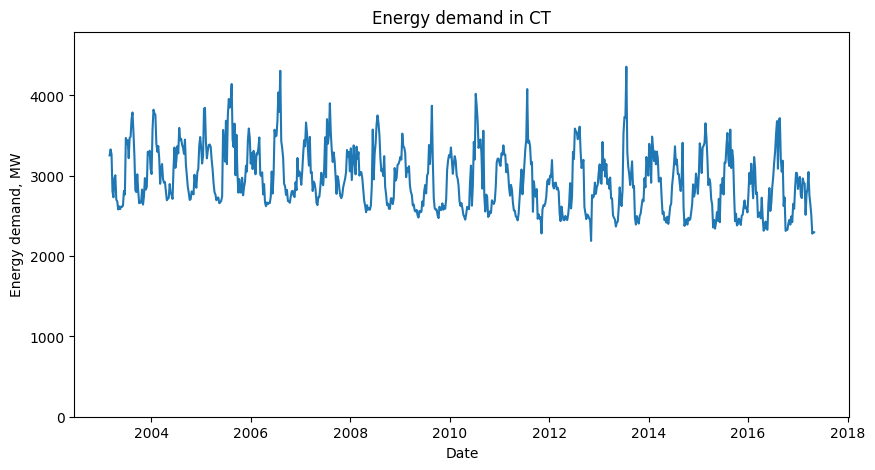

In [28]:
plot_energy_demand(data, scale=False, title="Energy demand in CT")

In [29]:
# show the data
data.head()

zone,CT
ts,
2003-03-02,3254.000000
2003-03-09,3328.714286
2003-03-16,3268.714286
2003-03-23,2805.571429
2003-03-30,2732.285714


In [30]:
# What are the data types?
data.dtypes



zone
CT    float64
dtype: object

In [31]:
# Check that the index of the Pandas DataFrame is a DatetimeIndex

print(f"Type of index: {type(data.index)}")

# show us what that looks like
print(data.index[:5])

Type of index: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
DatetimeIndex(['2003-03-02', '2003-03-09', '2003-03-16', '2003-03-23',
               '2003-03-30'],
              dtype='datetime64[ns]', name='ts', freq='W-SUN')


In [32]:
# show us the frequency of the data
print(f"Frequency of data: {data.index.freq}")

# What does weekday=6 mean?
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.weekday.html
data.index.weekday[:5]

Frequency of data: <Week: weekday=6>


Int64Index([6, 6, 6, 6, 6], dtype='int64', name='ts')

Note: this may help us spot missing data, which will be addressed further on

## 2. Splitting into training and test sets

**Why We Don't Shuffle Time Series Data Before Splitting**

In time series analysis, it's important to maintain the temporal order of the data when splitting into training and testing sets. This is because the inherent chronological order helps capture underlying patterns and trends that are essential for accurate forecasting.

Imagine you have a timeline of data points representing electricity consumption for every week over five years:  
```[Year 1 Week 1] -> [Year 1 Week 2] -> ... -> [Year 5 Week 52]```

To split this data for time series analysis, you would divide it into two contiguous segments without shuffling:  

* **Training Set**: This would include the initial years, say the first four years of data. It's like taking the first long piece of the timeline and using it to understand the pattern.   
```  [Year 1 Week 1] -> ... -> [Year 4 Week 52]```

* **Test Set**: This would consist of the last year of data, following immediately after the training set. It's like taking the remaining piece of the timeline to test if the patterns you found in the training set can predict these future points.  
```  [Year 5 Week 1] -> ... -> [Year 5 Week 52]```

By **not** shuffling, you're respecting the flow of time, ensuring that the training set only includes data from before the test set. This way, when you build a model, it learns to predict the future based on the past, just like you would in real life. If you shuffled the data, the model might learn to predict the past based on the future, which is not how time works and would lead to inaccurate predictions.


In [33]:
# Here we split the data into training and test sets
# We will use the first 80% of the data for training
# and the last 20% for testing

# get the length of the data
length = len(data)

# get the index of the last training data point
last_training_index = int(length * 0.8)

# get the index of the first test data point
first_test_index = last_training_index + 1

# get the training data
training_data = data.iloc[:last_training_index]

# get the test data
test_data = data.iloc[first_test_index:]


In [34]:
# or a quicker way to do the same thing with SciKit-Learn

from sklearn.model_selection import train_test_split

# split the data into training and test sets
training_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

training_data.shape, test_data.shape

((592, 1), (148, 1))

## Is the data stationary?

## Understanding **Stationarity** in Time Series Data

Stationarity is a foundational concept in time series analysis that refers to a time series whose statistical properties do not change over time. This means that the mean, variance, and autocorrelation (the relationship of the series with its past values) remain constant.

### Visual Examples of Stationary vs. Non-Stationary Series

  ![Stationary Series](https://www.dropbox.com/s/n91az56yewh71j2/Screenshot%202024-03-19%20at%2011.14.05.png?dl=1)

- **Stationary Series:** The series fluctuates around a constant mean and variance over time.
  
- **Non-Stationary Series:** The series shows trends, varying mean or variance over time.
  
### Simplified Explanation of the Augmented Dickey–Fuller (ADF) Test

The ADF test is a statistical test used to determine whether a time series is stationary. Here's how it works in practice:

- **Null Hypothesis (H0):** The time series has a unit root, meaning it is non-stationary.
- **Alternative Hypothesis (H1):** The time series does not have a unit root, meaning it is stationary.

When we perform the ADF test, we get a p-value:

- **If the p-value is less than a threshold (commonly 0.05),** we reject the null hypothesis and conclude the series is stationary.
- **If the p-value is greater than the threshold,** we fail to reject the null hypothesis and conclude the series is non-stationary.


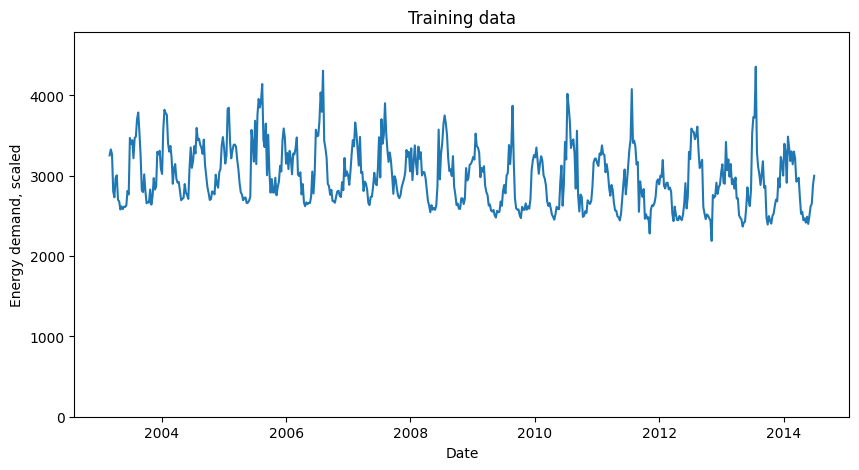

Test Statistic,-11.074
P-value,0.000
Lags,9


In [48]:
plot_energy_demand(training_data, title="Training data")

ADF(training_data['CT'])

The "Lags" value of 9 in the Augmented Dickey-Fuller (ADF) test results indicates that the test has taken into account 9 previous time periods (or lags) to account for autocorrelation when testing for stationarity. This means that the test has included 9 lagged versions of the time series in the regression model it uses to determine the presence of a unit root.

In [49]:
def __check_for_stationarity(data: pd.DataFrame) -> bool:
    """
    Checks if the data is stationary using the Augmented Dickey-Fuller test.
    A p-value of less than 0.05 indicates that the data is stationary.
    """
    adf = ADF(data['CT'])
    print(adf)

    return adf.pvalue < 0.05


print(f"\n\nIs the training data stationary? {__check_for_stationarity(training_data)}")

   Augmented Dickey-Fuller Results   
Test Statistic                -11.074
P-value                         0.000
Lags                                9
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Is the training data stationary? True


## Exploratory Data Analysis (EDA) Techniques for Time Series Analysis

Exploratory Data Analysis (EDA) is crucial in understanding the underlying structures of time series data. Here we will go through some key techniques.







### what's the number of lags we want to plot?
* A "lag" is the time difference between two observations in a time series.
* In ACF/PACF, it's the gap we look back to compare past data with current data.
* For weekly data, Lag 1 compares this week to last week, Lag 2 compares this week to two weeks ago, and so on.

## Cheatsheet for determining the number of lags

Here's a table for determining the number of lags to plot for ACF and PACF based on the frequency and domain type of your data. Note that the number of lags for ACF and PACF plots can be the same, but you may choose to adjust them based on the specific characteristics of your data.

### Lags by frequency of dataset

| Frequency Type  | Suggested Number of Lags for ACF & PACF | Justification                                             |
|-----------------|-----------------------------------------|------------------------------------------------------------|
| Daily data      | 30                                      | Covers about one month, capturing short-term dependencies  |
| Weekly data     | 52                                      | Covers an entire year, capturing seasonal patterns         |
| Monthly data    | 24                                      | Covers two years, capturing yearly and bi-yearly patterns  |
| Quarterly data  | 8                                       | Covers two years, capturing yearly patterns                |
| Annual data     | 10                                      | Covers a decade, capturing long-term patterns              |


### Lags by dataset domain

| Domain Type          | Frequency   | Suggested Number of Lags for ACF & PACF | Justification                                         |
|----------------------|-------------|-----------------------------------------|-------------------------------------------------------|
| Finance (e.g., stocks)| Daily       | 20-30                                   | Captures short-term trends and potential seasonal effects  |
| Climate (e.g., temperature) | Monthly | 30-50                             | Captures both seasonal patterns and long-term trends       |
| Macro-economics      | Quarterly   | 10-20                                   | Captures business cycle fluctuations and long-term trends  |
| Retail sales         | Monthly     | 12                                      | Captures seasonal patterns and promotions effects         |
| Energy consumption   | Hourly      | 24-168                                  | Captures daily and weekly patterns in energy usage         |





### Autocorrelation Function (ACF)

- **What is ACF?** It measures the correlation between a time series and a lagged version of itself.
- **Why use ACF?** To identify the presence of time dependency patterns. For instance, how today's electricity demand correlates with past weeks'.

Text(0.5, 1.0, 'Autocorrelation Function (ACF)')

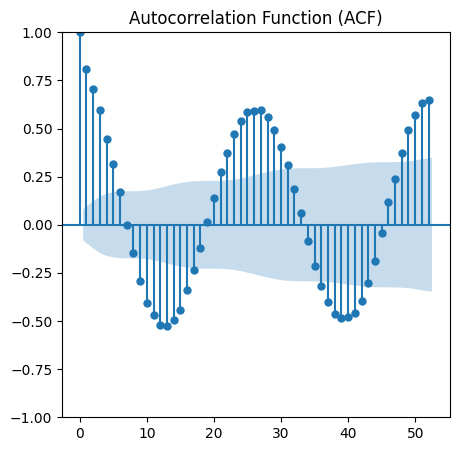

In [41]:

# what's the number of lags we want to plot?
# In our case, we will use 52 lags, which corresponds to the number of weeks in a year.

number_of_lags = 52


# plot the autocorrelation and partial autocorrelation plots nicely side by side
fig, ax1 = plt.subplots(1, figsize=(5, 5))
plot_acf(training_data, ax=ax1, lags=number_of_lags)
ax1.set_title('Autocorrelation Function (ACF)')

### Partial Autocorrelation Function (PACF)

- **What is PACF?** It measures the correlation between a time series and its lag, after removing the effect of previous lags.
- **Why use PACF?** To find the order of an autoregressive (AR) model. For example, it can show if the demand three weeks ago has a direct effect on today's demand.

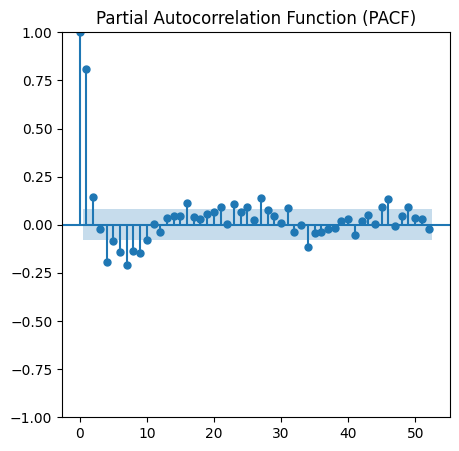

In [43]:
# What is a partial auto-correlation plot?
# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html
# A partial autocorrelation is the correlation between a variable and a lag of itself that is not explained by the correlations at all shorter lags.
fig, ax2 = plt.subplots(1, figsize=(5, 5))
plot_pacf(training_data, ax=ax2, lags=number_of_lags, method="ywm")
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.show()

## Cheat sheet for interpreting ACF and PACF plots

| Plot   | Pattern                                | Interpretation                             |
|--------|----------------------------------------|--------------------------------------------|
| ACF    | Gradual decline                        | Autoregressive (AR) component may be present |
| ACF    | Drops off quickly and remains near zero | Moving average (MA) component may be present |
| ACF    | Oscillating                            | Seasonal component may be present           |
| PACF   | Sharp drop after a certain lag         | AR component with an order equal to that lag |
| PACF   | Gradual decline                        | MA component may be present                |



When the ACF plot exhibits an oscillating pattern, it may indicate the presence of a seasonal component in the time series. In such cases, you may want to consider using a seasonal model (e.g., SARIMA) or a model that can capture seasonality (e.g., Facebook's Prophet, LSTM with seasonal input features).

## Seasonal decomposition

- **What is Decomposition?** It breaks down a time series into trend, seasonality, and residuals.
- **Why Decompose?** To understand the underlying trend, capture seasonal effects, and identify irregularities.
- **Types of Decomposition:**
  - **Additive:** When seasonal variations are roughly constant throughout the series.
  - **Multiplicative:** When seasonal variations change proportionally to the level of the time series.


### Is the model additive or multiplicative?

**Additive vs Multiplicative Seasonality**

In time series data, seasonality can be either additive or multiplicative. The key difference between the two lies in how the seasonal component interacts with the data.

![Visual Examples](https://tse1.mm.bing.net/th?id=OIP.Nlb0KtOISQ00I7_85veuagHaC7&pid=Api)

**Additive Seasonality:** The seasonal component is added to the trend and other components of the time series. The amplitude of the seasonal pattern remains constant over time, and fluctuations in the data are relatively constant or change linearly. 

Example: Sales of a product remain stable throughout the year but increase by a fixed amount during the holiday season.

**Multiplicative Seasonality:** The seasonal component is multiplied by the trend and other components of the time series. The amplitude of the seasonal pattern increases or decreases over time, and fluctuations in the data change exponentially. 

Example: Sales of a product increase over time, but the percentage increase during the holiday season is consistent, leading to larger absolute increases in sales as the trend grows.


| Characteristic                 | Additive Seasonality                 | Multiplicative Seasonality          |
|--------------------------------|--------------------------------------|-------------------------------------|
| Seasonal pattern amplitude     | Remains constant over time           | Increases or decreases over time    |
| Fluctuations in data           | Remain constant or change linearly   | Change exponentially                |
| Data transformation            | No transformation required           | Log transformation stabilizes pattern |


Q: Can I determine whether the model is additive or multiplicative automatically?  
\
    Automatically determining the seasonality type is not straightforward. You can try fitting both additive and multiplicative models and compare their performances using a metric like AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion). The model with the lower value of the chosen metric is generally preferred.
    Ideally it is best to use a grid search to identify the best fit.
    
We will now use the statsmodels "seasonal_decompose" method.
    

## Choosing the "Period" for Seasonal Decomposition

When performing seasonal decomposition on time series data, it's crucial to correctly specify the `period` parameter. This parameter represents the length of the seasonal cycle and is essential for accurately capturing the seasonality of the dataset.

Here's how to choose the `period` for different data frequencies:

- **Yearly data:** The period is typically 1 because there's one cycle per year.
- **Quarterly data:** Use a period of 4, as there are four quarters in a year.
- **Monthly data:** Set the period to 12 to represent the 12 months in a year.
- **Weekly data:** A period of 52 is appropriate for the 52 weeks in a year.
- **Daily data:** For daily data, the period depends on the context, such as 7 for weekly patterns or 365 for yearly patterns.

### Intuitive Example of Seasonal Decomposition

Consider a dataset of weekly sales data for a retail store. You notice that sales peak every December during the holiday season and dip in January. To analyze this, you would set the `period` to 52 when performing seasonal decomposition, as you're looking at weekly data and want to capture the annual seasonality.


### Do we have enough datapoints?
* Ideally we need 2-3 years' worth to run a decomposition






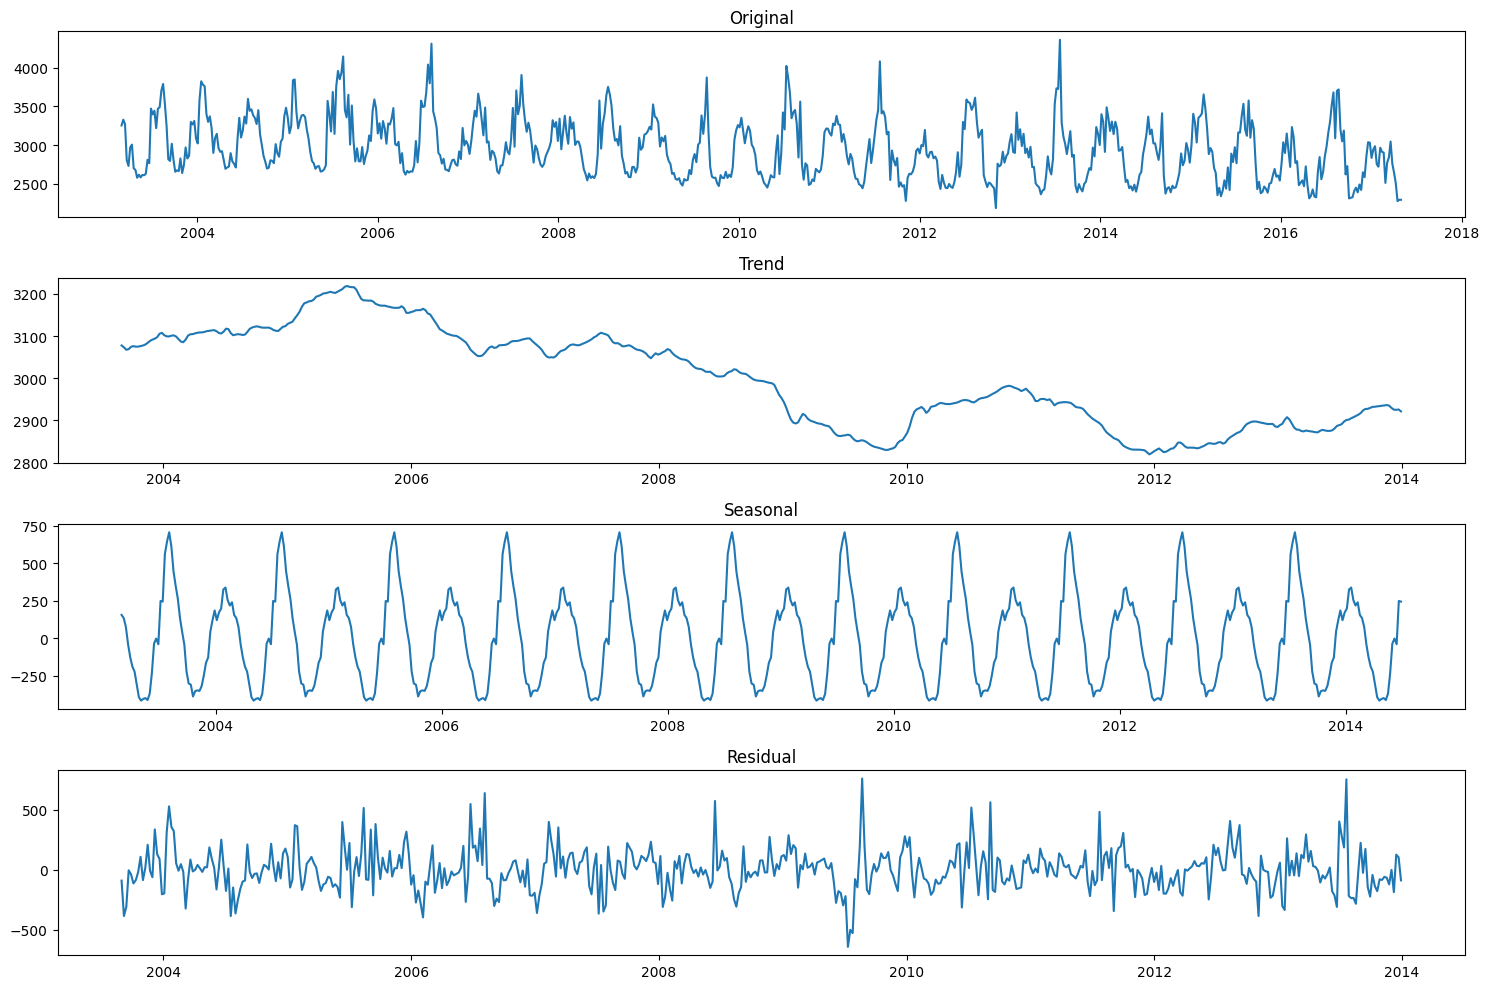

In [50]:
# Decomposing the time series - additive model

from statsmodels.tsa.seasonal import seasonal_decompose

# decompose the time series
decomposition_additive = seasonal_decompose(training_data, model="additive", period=52) 

# plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
ax1.plot(data)
ax1.set_title("Original")
ax2.plot(decomposition_additive.trend)
ax2.set_title("Trend")
ax3.plot(decomposition_additive.seasonal)
ax3.set_title("Seasonal")
ax4.plot(decomposition_additive.resid)
ax4.set_title("Residual")
plt.tight_layout()
plt.show()




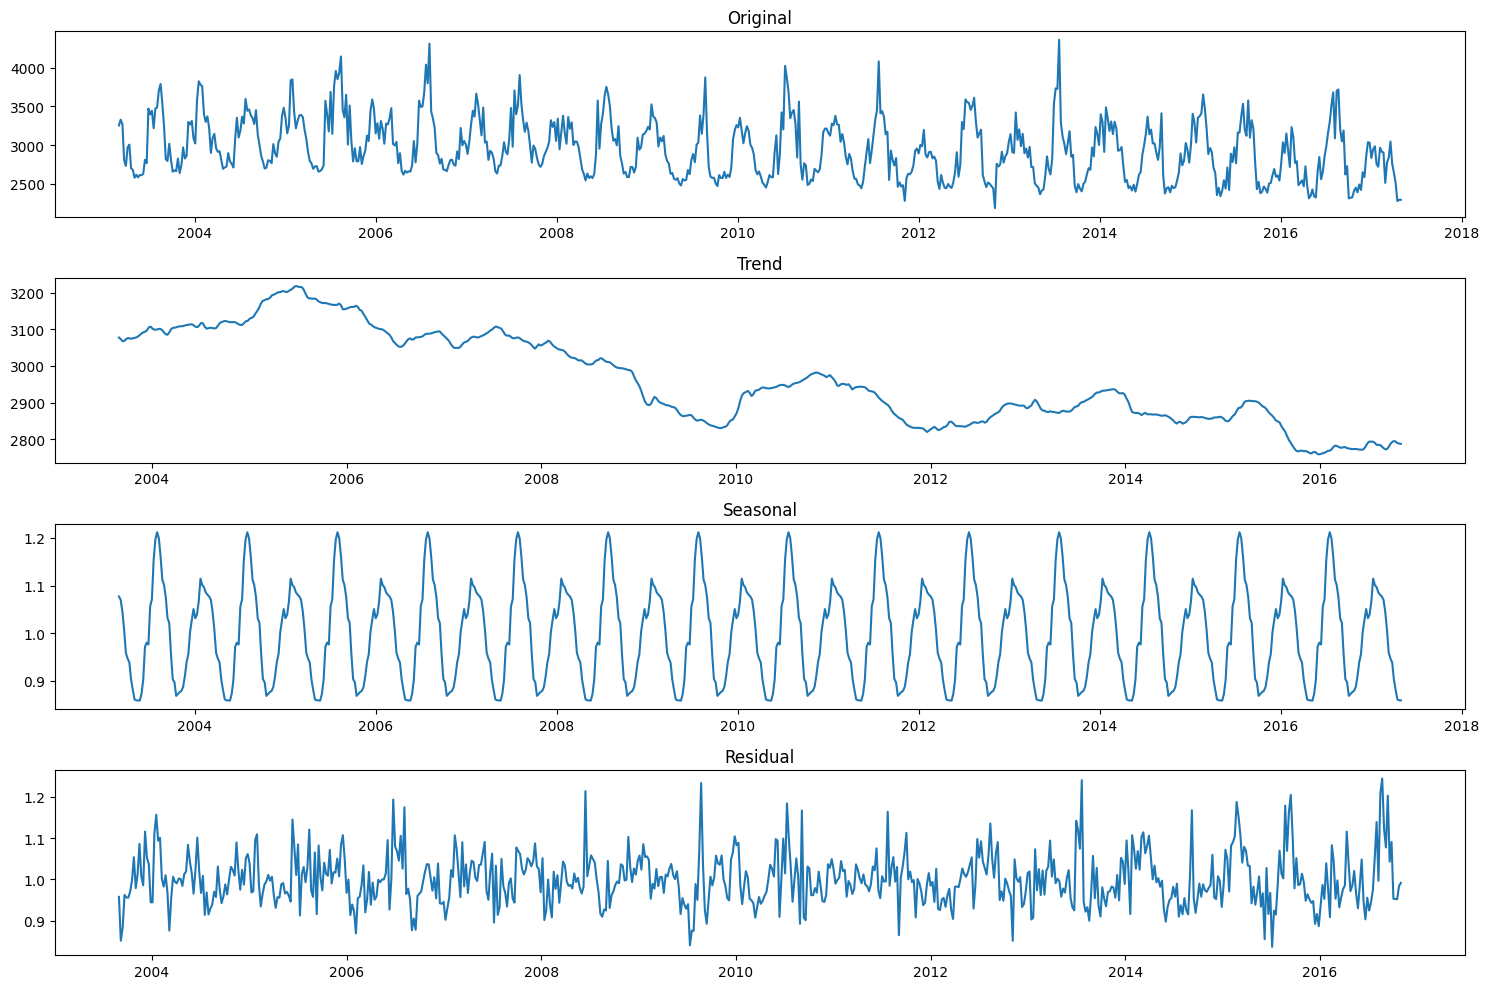

In [51]:
# Decomposing the time series - multiplicative model

# decompose the time series
decomposition_multiplicative = seasonal_decompose(data, model="multiplicative", period=52)

# plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
ax1.plot(data)
ax1.set_title("Original")
ax2.plot(decomposition_multiplicative.trend)
ax2.set_title("Trend")
ax3.plot(decomposition_multiplicative.seasonal)
ax3.set_title("Seasonal")
ax4.plot(decomposition_multiplicative.resid)
ax4.set_title("Residual")
plt.tight_layout()
plt.show()



## More advanced approach to seasonal decomposition; using Seasonal trend decomposition (STL)


## Understanding the STL Method

STL stands for "Seasonal and Trend decomposition using Loess," which is a more flexible approach to decomposing a time series into seasonal, trend, and residual components.


### Intuitive Example of STL Decomposition

Imagine you're analyzing electricity consumption data with both strong seasonal patterns and unusual events (like a heatwave leading to increased air conditioning use). STL can handle this well because it allows for changing seasonality over time, which is not possible with classical decomposition methods.


Q: What's the difference between the seasonal and the period arguments in statsmodels.tsa.seasonal.STL?

| Frequency | Seasonal | Period |
|-----------|----------|--------|
| Hourly    | 24       | 24     |
| Daily     | 7        | 365    |
| Weekly    | 52       | 52     |
| Monthly   | 12       | 12     |
| Quarterly | 4        | 4      |
| Yearly    | 1        | 1      |


The seasonal argument specifies the number of observations in each seasonal period (e.g. 24 hours in a day for hourly data), while the period argument specifies the number of observations in a complete cycle of seasonality (e.g. 168 hours in a week for hourly data).








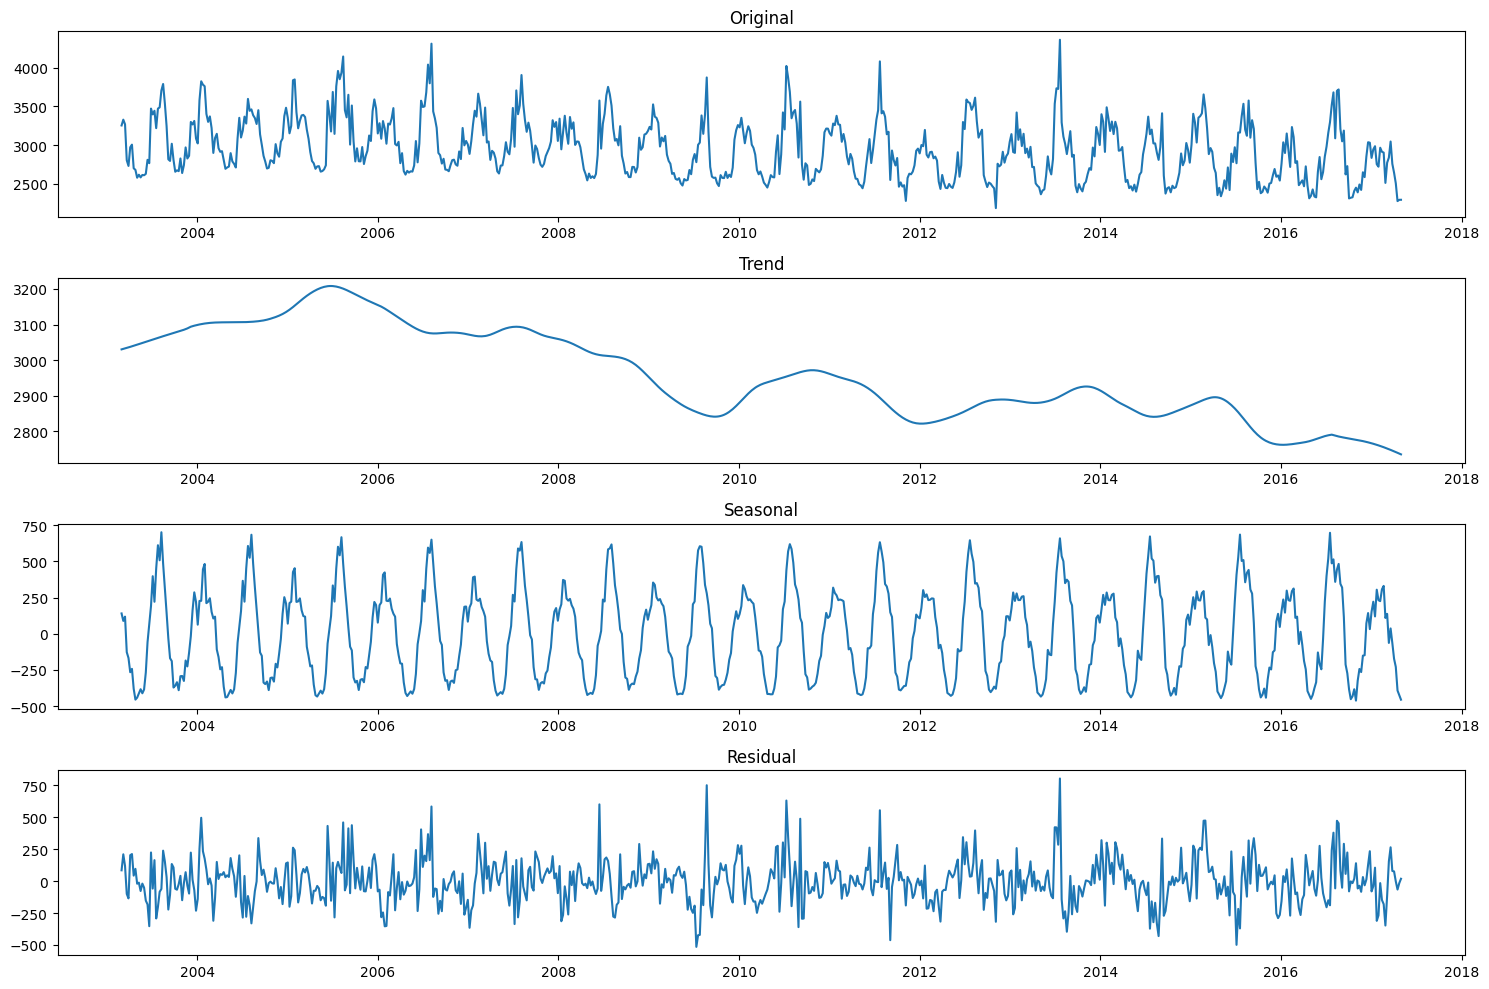

In [42]:
# Seasonal decomposition using the STL method

from statsmodels.tsa.seasonal import STL

# decompose the time series
decomposition_STL = STL(data, seasonal=53, period=52).fit()

# plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
ax1.plot(data)
ax1.set_title("Original")
ax2.plot(decomposition_STL.trend)
ax2.set_title("Trend")
ax3.plot(decomposition_STL.seasonal)
ax3.set_title("Seasonal")
ax4.plot(decomposition_STL.resid)
ax4.set_title("Residual")
plt.tight_layout()
plt.show()

